## Import Libraries

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, GlobalAveragePooling1D,GRU,LSTM,Bidirectional,Dropout,BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import zipfile
import re
import string
import nltk
import torch



## Data Downloading

In [3]:
# zip_path = "/content/IMDB Dataset.csv.zip"
# extract_to = "data/"
# # Open the zip file
# with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#     # Extract specific files
#     zip_ref.extract("IMDB Dataset.csv", extract_to)

In [4]:
train_data = pd.read_csv("/kaggle/input/dataset-imdb/IMDB Dataset.csv")
train_df, test_df = train_test_split(train_data, test_size=0.1, random_state=42)

In [5]:
# download stopwords
nltk.download("stopwords")

stop_words = set(stopwords.words("english"))

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## Data Preprocessing

In [6]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r"\d+", "", text)
    text = text.translate(str.maketrans("", "", string.punctuation))
    text = " ".join([word for word in text.split() if word not in stop_words])
    text = re.sub(r"\s+", " ", text).strip()
    return text

train_df["review"] = train_df["review"].apply(preprocess_text)
test_df["review"] = test_df["review"].apply(preprocess_text)

In [7]:
# separate review and sentiment
X_train = train_df["review"].values
y_train = train_df["sentiment"].values
X_test = test_df["review"].values
y_test = test_df["sentiment"].values

print("y_train type:", type(y_train))
print("Unique values in y_train:", np.unique(y_train))

# map 1->positive, 0->negative
if y_train.dtype == 'O':
    label_mapping = {'positive': 1, 'negative': 0}
    y_train = np.array([label_mapping[label] for label in y_train], dtype=np.float32)
    y_test = np.array([label_mapping[label] for label in y_test], dtype=np.float32)
else:
    y_train = y_train.astype(np.float32)
    y_test = y_test.astype(np.float32)

MAX_WORDS = 10000
MAX_LEN = 500

EMBEDDING_DIMS = 128

# Tokenize
tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

y_train type: <class 'numpy.ndarray'>
Unique values in y_train: ['negative' 'positive']


## Build Model

#### Vanilla RNN Model

In [8]:
# Vanilla RNN model
def create_rnn_model():
    model = Sequential([
        Embedding(input_dim=MAX_WORDS, output_dim=EMBEDDING_DIMS, mask_zero=True),  # mask_zero=True
        SimpleRNN(128, dropout=0.2, recurrent_dropout=0.2, return_sequences=False),  # return_sequences=False -> output 2D
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [9]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

#### GRU Model

In [10]:

# from tensorflow.keras.layers import GRU, Dense, Embedding, Bidirectional, BatchNormalization, Dropout
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.regularizers import l2

# def create_gru_model():
#     model = Sequential([
#         # Embedding Layer với mask_zero để xử lý padding
#         Embedding(
#             input_dim=MAX_WORDS,
#             output_dim=EMBEDDING_DIMS,
#             input_length=MAX_LEN,
#             mask_zero=True
#         ),

#         # Stacked Bidirectional GRU Layers
#         GRU(
#             128,
#             return_sequences=True,
#             dropout=0.3,          # Dropout cho đầu vào
#             recurrent_dropout=0.2, # Dropout cho recurrent state
#             kernel_regularizer=l2(1e-4)
#         ),
#         BatchNormalization(),

#         GRU(
#             64,
#             return_sequences=False, # Layer cuối không cần return sequences
#             dropout=0.2,
#             recurrent_dropout=0.1
#         ),
#         Dropout(0.3),

#         Dense(32, activation='relu', kernel_regularizer=l2(1e-4)),
#         BatchNormalization(),
#         Dropout(0.2),

#         # Output Layer
#         Dense(1, activation='sigmoid')
#     ])

#     # optimize
#     optimizer = Adam(
#         learning_rate=1e-3,
#         clipnorm=1.0  # avoid exploding gradients
#     )

#     model.compile(
#         optimizer=Adam(learning_rate=1e-4),
#         loss='binary_crossentropy',
#         metrics=['accuracy']
#     )
#     return model
from tensorflow.keras.layers import GRU, Dense, Embedding, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

def create_gru_model():
    model = Sequential([
        Embedding(
            input_dim=MAX_WORDS,
            output_dim=EMBEDDING_DIMS,
            input_length=MAX_LEN,
            mask_zero=True
        ),

        # Dropout cho embedding layer
        Dropout(0.3),

        # GRU Layer 1
        GRU(
            128,
            return_sequences=True,
            dropout=0.3,
            recurrent_dropout=0.2,
            kernel_regularizer=l2(1e-4)
        ),
        # GRU Layer 2
        GRU(
            64,
            dropout=0.2,
            recurrent_dropout=0.1
        ),
        # Hidden Layer với regularization
        Dense(32, activation='relu', kernel_regularizer=l2(1e-4)),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])
    model.compile(
        optimizer=Adam(learning_rate=1e-4),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model



#### LSTM Model

In [11]:
# LSTM model
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

from tensorflow.keras.layers import Bidirectional, LSTM, Dropout, BatchNormalization, Dense
from tensorflow.keras.regularizers import l2

def create_lstm_model():
    model = Sequential([
        # embedding
        Embedding(input_dim=MAX_WORDS, output_dim=64, mask_zero=True),

        # optimized bidirectional LSTM
        Bidirectional(LSTM(32, return_sequences=True)),
        BatchNormalization(),

        Bidirectional(LSTM(16)),
        Dropout(0.1),

        # dense layers with reduced regularization
        Dense(16, activation="relu"),
        BatchNormalization(),

        # Output layer
        Dense(1, activation="sigmoid")
    ])

    model.compile(
        optimizer=Adam(learning_rate=1e-4),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

## Train Model

#### Train Vanilla RNN Model

In [12]:
# convert text data to sequences of integers using the tokenizer
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# padding sequence
X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LEN, padding="post")
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_LEN, padding="post")


In [13]:
# train Vanilla RNN model
rnn_model = create_rnn_model()
X_train_tensor = np.array(X_train_pad, dtype=np.int32)
y_train_tensor = np.array(y_train, dtype=np.float32)
X_test_tensor = np.array(X_test_pad, dtype=np.int32)
y_test_tensor = np.array(y_test, dtype=np.float32)

# train model
history_rnn = rnn_model.fit(
    X_train_tensor, y_train_tensor,
    validation_data=(X_test_tensor, y_test_tensor),
    epochs=10, batch_size=64
)


Epoch 1/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 40s 51ms/step - accuracy: 0.5122 - loss: 0.7041 - val_accuracy: 0.5686 - val_loss: 0.6760
Epoch 2/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 33s 47ms/step - accuracy: 0.5810 - loss: 0.6679 - val_accuracy: 0.5832 - val_loss: 0.6476
Epoch 3/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 33s 47ms/step - accuracy: 0.6630 - loss: 0.6040 - val_accuracy: 0.6258 - val_loss: 0.6288
Epoch 4/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 33s 47ms/step - accuracy: 0.7103 - loss: 0.5552 - val_accuracy: 0.7568 - val_loss: 0.5251
Epoch 5/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 33s 47ms/step - accuracy: 0.7813 - loss: 0.4641 - val_accuracy: 0.7130 - val_loss: 0.5637
Epoch 6/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 33s 47ms/step - accuracy: 0.8046 - loss: 0.4329 - val_accuracy: 0.6820 - val_loss: 0.5896
Epoch 7/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 33s 47ms/step - accuracy: 0.7876 - loss: 0.4535 - val_accuracy: 0.7844 - val_loss: 0.4964
Epoch 8/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 33s 47ms/step - accuracy: 0.8315 - loss: 0.3916 - 

#### Train GRU Model

In [14]:
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# padding
X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LEN, padding="post")
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_LEN, padding="post")


In [15]:
# train GRU model
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
gru_model = create_gru_model()
history_gru = gru_model.fit(X_train_pad, y_train, validation_data=(X_test_pad, y_test),
                            epochs=3, batch_size=128, callbacks=[early_stopping])

Epoch 1/3


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


352/352 ━━━━━━━━━━━━━━━━━━━━ 719s 2s/step - accuracy: 0.5636 - loss: 2.6086 - val_accuracy: 0.7842 - val_loss: 0.5466
Epoch 2/3
352/352 ━━━━━━━━━━━━━━━━━━━━ 711s 2s/step - accuracy: 0.8174 - loss: 0.5451 - val_accuracy: 0.8066 - val_loss: 0.5118
Epoch 3/3
352/352 ━━━━━━━━━━━━━━━━━━━━ 711s 2s/step - accuracy: 0.8575 - loss: 0.3697 - val_accuracy: 0.8194 - val_loss: 0.4903


In [16]:
# Define tokenizer (adjust num_words if needed)
tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)  # Fit tokenizer on training data

# Convert text to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# pad the sequences
X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LEN, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_LEN, padding='post')

In [17]:
# Train LSTM model
lstm_model = create_lstm_model()
history_lstm = lstm_model.fit(X_train_pad, y_train, validation_data=(X_test_pad, y_test),
                              epochs=5, batch_size=64, callbacks=[early_stopping])

Epoch 1/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 48s 62ms/step - accuracy: 0.5946 - loss: 0.7258 - val_accuracy: 0.8184 - val_loss: 0.4064
Epoch 2/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 43s 61ms/step - accuracy: 0.8586 - loss: 0.3321 - val_accuracy: 0.8756 - val_loss: 0.2895
Epoch 3/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 42s 60ms/step - accuracy: 0.9154 - loss: 0.2215 - val_accuracy: 0.8786 - val_loss: 0.3022
Epoch 4/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 42s 60ms/step - accuracy: 0.9344 - loss: 0.1799 - val_accuracy: 0.8798 - val_loss: 0.3055
Epoch 5/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 42s 60ms/step - accuracy: 0.9466 - loss: 0.1501 - val_accuracy: 0.8828 - val_loss: 0.3012


### Plot results

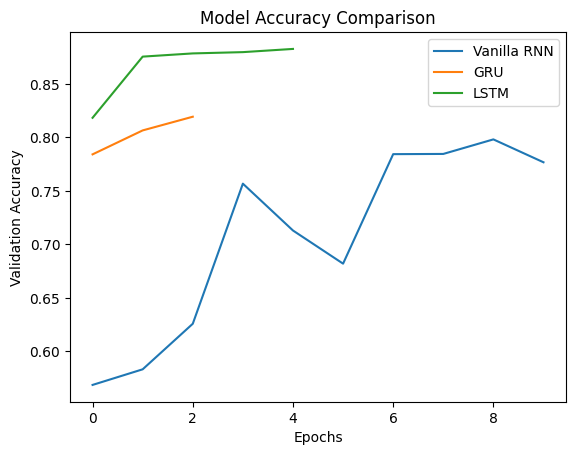

In [25]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.plot(history_rnn.history['val_accuracy'], label="Vanilla RNN")
plt.plot(history_gru.history['val_accuracy'], label="GRU")
plt.plot(history_lstm.history['val_accuracy'], label="LSTM")
plt.xlabel("Epochs")
plt.ylabel("Validation Accuracy")
plt.legend()
plt.title("Model Accuracy Comparison")
plt.show()


In [19]:
import matplotlib.pyplot as plt

def plot_accuracy(history):
    # Plots training and validation accuracy over epochs
    if hasattr(history, 'history'):  
        history = history.history

    epochs = range(1, len(history['accuracy']) + 1)

    plt.figure(figsize=(8, 5))
    plt.plot(epochs, history['accuracy'], label='Training Accuracy', marker='o')
    plt.plot(epochs, history['val_accuracy'], label='Validation Accuracy', marker='s')

    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training vs Validation Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

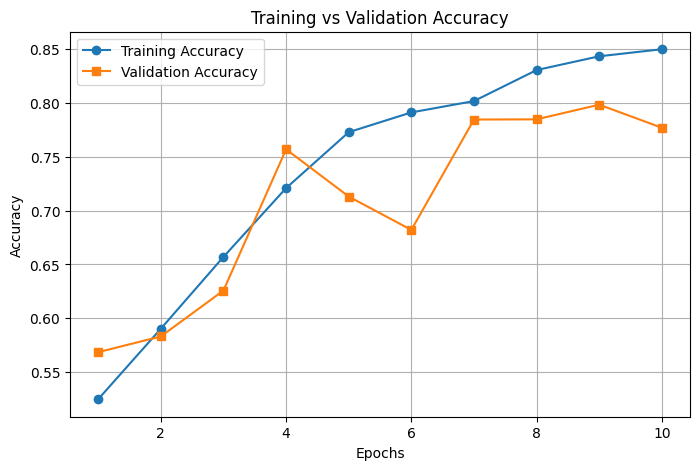

In [22]:
plot_accuracy(rnn_model.history)

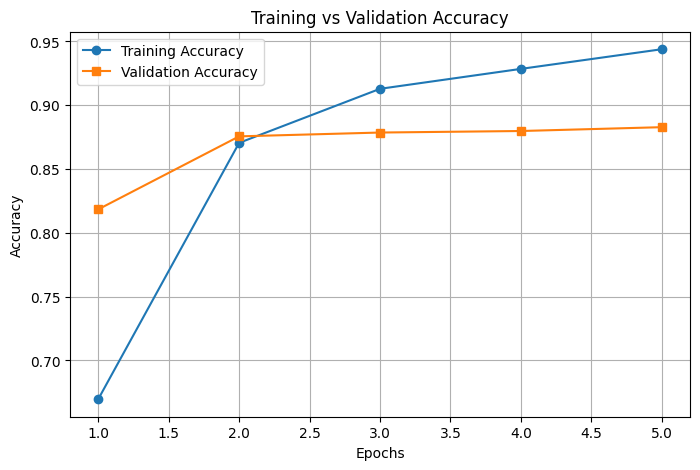

In [24]:
plot_accuracy(lstm_model.history)

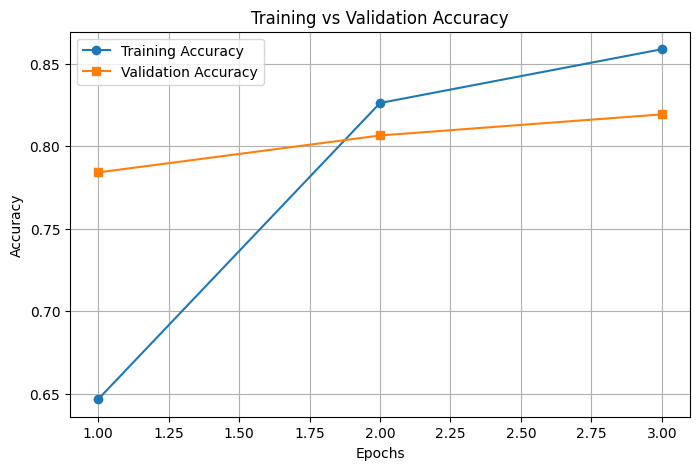

In [23]:
plot_accuracy(gru_model.history)